In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### Data

In [5]:
#DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [9]:
# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

In [10]:
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [12]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
41137,100976,18APR2014,SCH,M,27,N,N,0,0,-1.935686,1,70,2,3,45000,1,2,N,1,0
50254,65014,14MAR2014,SCH,F,52,N,N,0,1,-1.716158,1,60,2,3,20000,2,3,N,1,0
88960,65224,14MAR2014,SCH,M,42,Y,Y,0,0,-1.519214,0,50,2,3,40000,3,2,N,1,0
582,23949,30JAN2014,GRD,F,31,N,N,0,1,-2.025824,2,60,1,1,60000,1,3,N,0,0
43808,106984,26APR2014,GRD,F,50,Y,Y,0,0,-2.302099,3,60,2,3,50000,1,3,N,1,0


Описания полей

    client_id - идентификатор клиента
    education - уровень образования+
    sex - пол заемщика +
    age - возраст заемщика +
    car - флаг наличия автомобиля +
    car_type - флаг автомобиля иномарки +
    decline_app_cnt - количество отказанных прошлых заявок +
    good_work - флаг наличия “хорошей” работы+
    bki_request_cnt - количество запросов в БКИ +
    home_address - категоризатор домашнего адреса+
    work_address - категоризатор рабочего адреса+
    income - доход заемщика +
    foreign_passport - наличие загранпаспорта +
    sna - связь заемщика с клиентами банка +
    first_time - давность наличия информации о заемщике+
    score_bki - скоринговый балл по данным из БКИ+
    region_rating - рейтинг региона +
    app_date - дата подачи заявки + 
    default - флаг дефолта по кредиту - целевая переменная
    sample - принадлнжность к данным для обучения - метка (в анализе не участвует)

### Распредилим данные по типам

In [13]:
#данные в столбце sna
data['sna'].unique()

array([1, 4, 2, 3])

В столбце sna встречаются 4 уникальных числовых значения переменной. Отнесем данные в столбце к числовым переменным 

In [14]:
#данные в столбце first_time
data['first_time'].unique()

array([4, 3, 1, 2])

In [15]:
data['first_time'].value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

Отнесем данные в столбце first_time к категориальным. Будем считать 1 - обратился недавно, 4 - обратился давно, 2,3 - промежуточные значения. 

In [16]:
# Тип переменных
# Числовые переменные
num_cols = ['age','score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'sna', 'region_rating']
# Переменные времени
# app_date
# Категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'first_time']
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

## Работа с данными 

### Числовые переменные

In [17]:
data[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   age              110148 non-null  int64  
 1   score_bki        110148 non-null  float64
 2   decline_app_cnt  110148 non-null  int64  
 3   bki_request_cnt  110148 non-null  int64  
 4   income           110148 non-null  int64  
 5   sna              110148 non-null  int64  
 6   region_rating    110148 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 5.9 MB


Пропусков в данных нет, типы данных: 6 столбцов c целочиcленными данными, один столбец - с дробными
Проверим распределение числовых данных

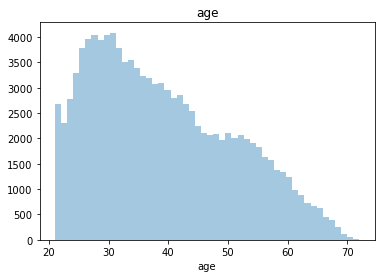

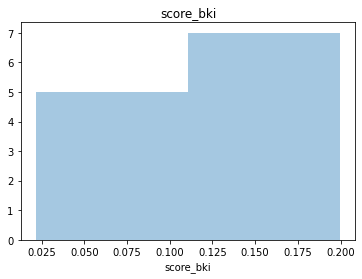

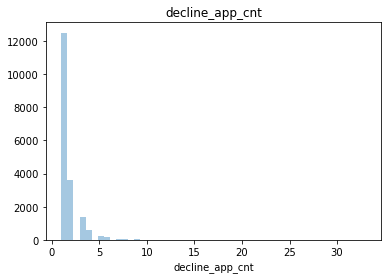

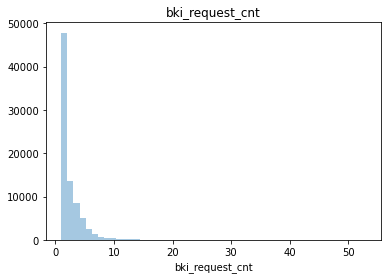

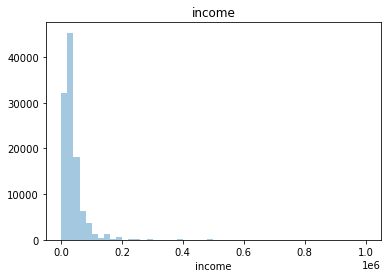

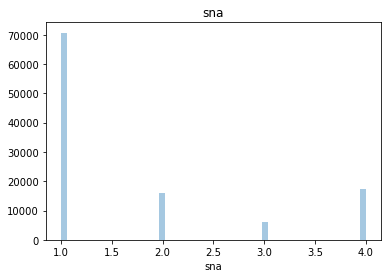

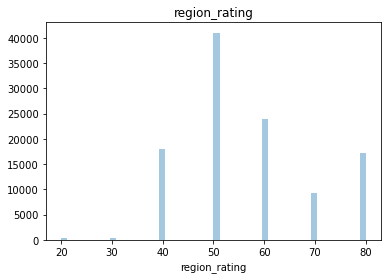

In [18]:
for i in data[num_cols]:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Выводы:
Распределения числовых переменных age,decline_app_cnt, bki_request_cnt, income имеют тяжёлый правый хвост. В дальнейшем будем работать с логарифмом этих данных.
Данные в столбце region_rating распределены нормально.
Распределение данных столбца score_bki рассмотрим дополнительно (имеются данные с отрицательными значениями, которые при построения диаграмм были не учтены)
Перенесем данные переменной sna из числовых в категориальные. 1 - нет связей, 4 - много связей, 2, 3 - промежуточные значения

In [19]:
num_cols = ['age','score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'region_rating']
cat_cols = ['education', 'home_address', 'work_address', 'first_time', 'sna']

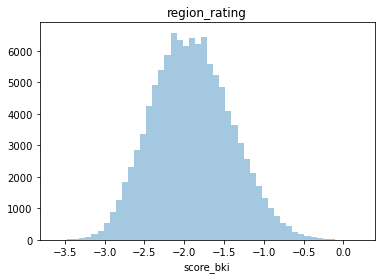

In [20]:
plt.figure()
sns.distplot(data['score_bki'].dropna(), kde = False, rug=False)
plt.title(i)
plt.show()

Данные в столбце region_rating распределены нормально. В столбце основной объем данных имеет отрицательное значение, некоторое кол-во - положительное.

In [21]:
data[data['score_bki'] > 0]['score_bki'].count()

12

поменяем знак для этих переменных в столбце score_bki с отрицательного на положительный. Данную операцию выполним, чтобы в дальнейшем прологарифмировать данные и уменьшить размерность величин 

In [22]:
data['score_bki'] = data['score_bki'].apply(lambda x: -1*x if x < 0  else x)

In [23]:
data[data['score_bki'] > 0]['score_bki'].count()

110148

Проверим данные на выбросы

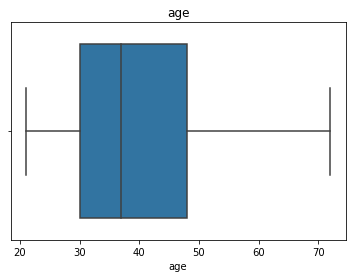

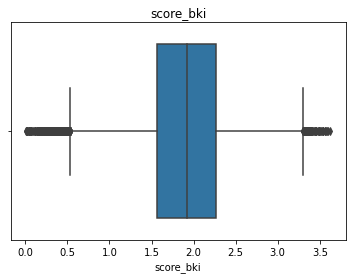

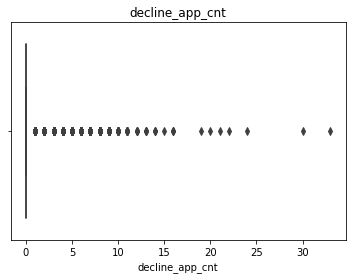

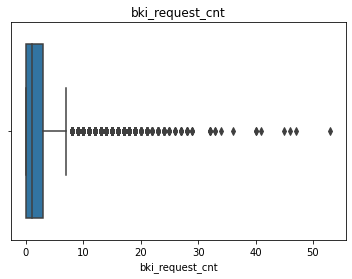

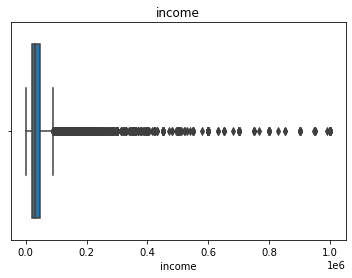

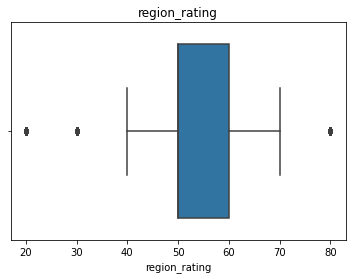

In [24]:
for i in data[num_cols]:
    plt.figure()
    sns.boxplot(data[i])
    plt.title(i)
    plt.show()

Из графиков boxplot видно:
    
    - данне в столбце age без выбросов;
    - данные в столбце score_bki и region_rating содержат данные не входящие в межквартильный интервал, но это скорее частные случаи, чем выбросы. Данные оставим без изменений.
    - данные в столбцах decline_app_cnt, bki_request_cnt и income требуют дополнительного анализа.

Данные в столбце decline_app_cnt и bki_request и income

In [25]:
data['decline_app_cnt'].value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

In [28]:
data['bki_request_cnt'].value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
23       12
24       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
33        2
40        2
41        1
46        1
45        1
47        1
36        1
34        1
53        1
Name: bki_request_cnt, dtype: int64

Данные попадающие в зону выбросов могут быть как выбросами, так и показывать на клиентов, многократно подающих запрос на получение кредита и получающие отказ. Данные оставлю без изменений.

Данные в столбце income.

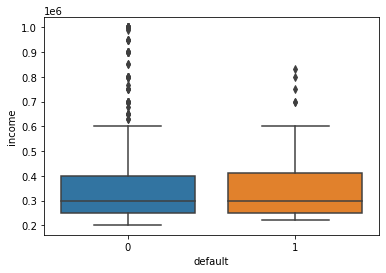

In [32]:
sns.boxplot(x = data[data['income'] > 200000]['default'], y = data[data['income'] > 200000]['income'])

Данные о доходах клиентов больше 200000 и имеющие флаг дефолта по кредиту - выбросы. Заменим на значение среднего. 

In [33]:
data[(data['income'] > 200000) & (data['default'] == 1)]['income'] = data['income'].median()

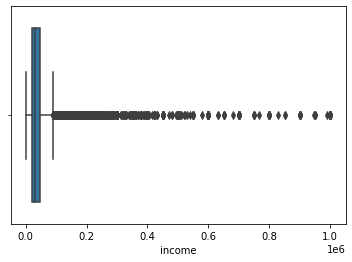

In [35]:
sns.boxplot(data['income'])

Прологарифмируем числовые данные

In [36]:
a_features = data[num_cols].values
norm_features = np.log(a_features+1)
data.loc[:, num_cols] = norm_features

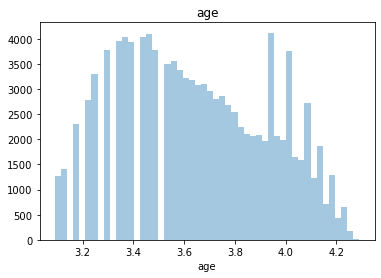

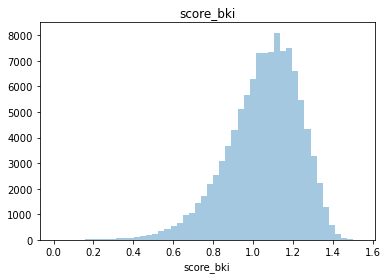

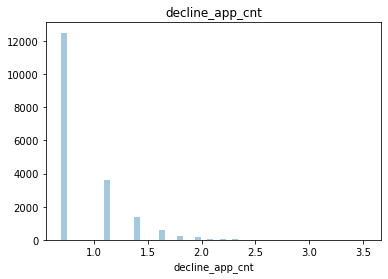

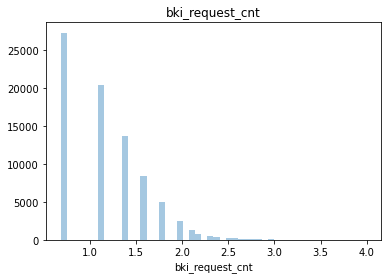

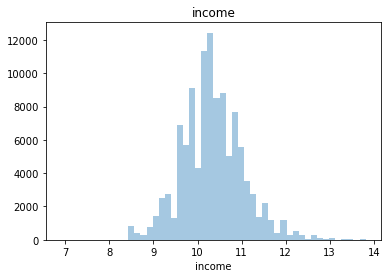

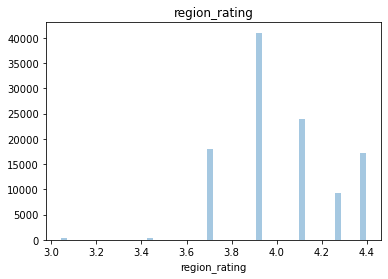

In [37]:
for i in data[num_cols]:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Вывод: По результатам логарифмирования числовых данных получаем: 1. Распределение данных столбца age, income, region_rating приблизилось к нормальному закону распределения; 2. Распределение данных столбца score_bki имеют тяжелый левый хвост; 3. На характер распределения данных в столбцах decline_app_cnt и bki_request_cnt логарифмирование не повлияло.

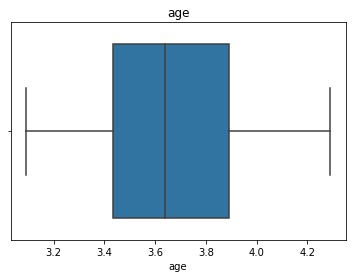

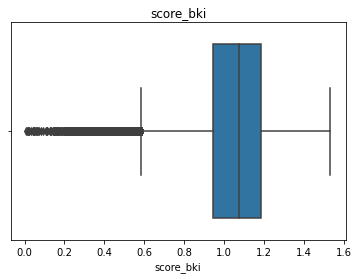

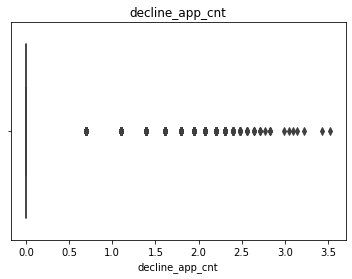

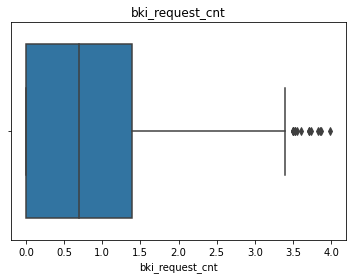

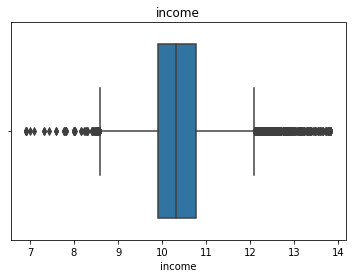

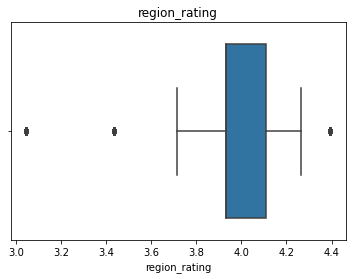

In [38]:
for i in data[num_cols]:
    plt.figure()
    sns.boxplot(data[i])
    plt.title(i)
    plt.show()

Оценим корреляцию Пирсона для числовых переменных

Оценим корреляцию Пирсона для числовых переменных

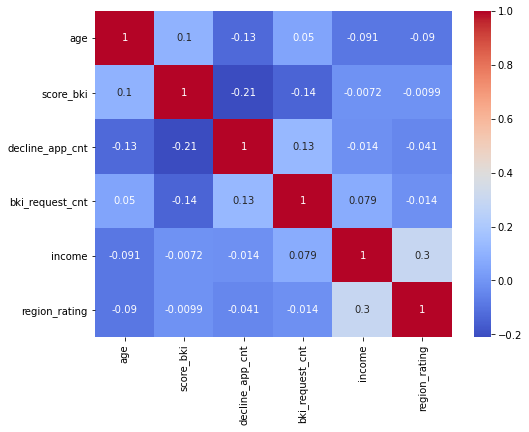

In [39]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data[num_cols].corr(),annot = True, cmap = 'coolwarm')

Данные в столбцах region_rating и income имеют максимальную положительную зависимость. Это говорит о том, что в регтонах с большим рейтингом, клиенты имеют больший доход. Данные в столбцах decline_app_cnt и score_bki имеют максимальную отрицательную зависимость, что говорит нам о том, что чем больше было отказов в прошлом, тем ниже рейтинг БКИ
По результатам корреляционного анализа данные для дальнейшего анализа изменять не будем.

### Проверим значимость числовых переменных


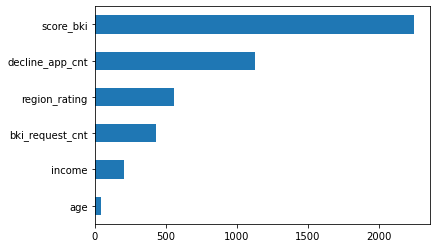

In [40]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Обработка переменной времени

In [41]:
data['app_date'] = pd.to_datetime(data.app_date, format='%d%b%Y')
data['app_date'].sample(5)

48978   2014-03-04
90205   2014-01-31
5155    2014-01-13
82829   2014-01-06
26079   2014-03-24
Name: app_date, dtype: datetime64[ns]

Проверим год даты подачи заявки

In [42]:
data['app_date'].dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

Все заявки в 2014 году

In [43]:
data['app_date'].dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

В данных представлены заявки за 4 месяца. Создадим столбец с категориальными данными. Примем: 1 - подача заявки в январе, 2 - в феврале и т.д.

In [44]:
data['month_app_date'] = data['app_date'].apply(lambda x: x.month)

In [45]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,month_app_date
85390,106145,2014-04-25,SCH,F,3.496508,N,N,0.000000,0,1.119779,...,3.044522,2,3,9.852247,1,3,N,1,0,4
66217,76664,2014-03-24,SCH,M,3.465736,N,N,0.693147,0,1.033046,...,3.931826,2,3,10.389026,3,1,N,1,0,3
109174,92706,2014-04-09,SCH,F,3.828641,Y,N,0.693147,0,1.133739,...,4.110874,2,3,9.903538,2,3,N,1,0,4
40283,30583,2014-02-06,GRD,F,4.127134,N,N,0.000000,1,1.348724,...,4.110874,2,3,10.275086,3,1,N,1,0,2
67224,40972,2014-02-17,SCH,F,4.110874,Y,N,0.000000,0,1.220844,...,4.110874,2,3,12.429220,2,1,N,1,1,2


In [46]:
# добавим month_app_data в список с категориальными данными
cat_cols = ['education', 'home_address', 'work_address', 'first_time', 'sna', 'month_app_date']

### Категориальные переменные

In [47]:
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   education       109670 non-null  object
 1   home_address    110148 non-null  int64 
 2   work_address    110148 non-null  int64 
 3   first_time      110148 non-null  int64 
 4   sna             110148 non-null  int64 
 5   month_app_date  110148 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 5.0+ MB


В столбце education присутствуют пропуски. Для дальнейшей работы нужно заполнить пропуски и зашифровать данные (перевести в формат int)

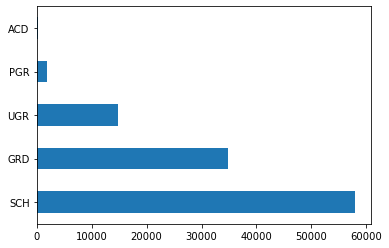

In [48]:
#распределение данных
data['education'].value_counts().plot.barh()

In [49]:
# заполним пропуски значением 'No_inf
data['education'] = data['education'].fillna('No_inf')

In [50]:
data['education'].value_counts()

SCH       57998
GRD       34768
UGR       14748
PGR        1865
No_inf      478
ACD         291
Name: education, dtype: int64

In [51]:
# шифруем переменные в education
dict_prise = {'No_inf' : 1,'ACD': 2,  'PGR' : 3, 'UGR' : 4, 'GRD': 5, 'SCH': 6}
data['education'] = data['education'].replace(to_replace = dict_prise)
data['education'].value_counts()

6    57998
5    34768
4    14748
3     1865
1      478
2      291
Name: education, dtype: int64

In [52]:
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   education       110148 non-null  int64
 1   home_address    110148 non-null  int64
 2   work_address    110148 non-null  int64
 3   first_time      110148 non-null  int64
 4   sna             110148 non-null  int64
 5   month_app_date  110148 non-null  int64
dtypes: int64(6)
memory usage: 5.0 MB


### Бинарные признаки

In [53]:
data[bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   sex               110148 non-null  object
 1   car               110148 non-null  object
 2   car_type          110148 non-null  object
 3   foreign_passport  110148 non-null  object
 4   good_work         110148 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.2+ MB


все столбцы, кроме good_work, имеют тип object. Используем LabelEncoder для кодирования бинарных переменных

In [54]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in ['sex', 'car', 'car_type', 'foreign_passport']:
    data[column] = label_encoder.fit_transform(data[column])

In [55]:
data[bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   sex               110148 non-null  int64
 1   car               110148 non-null  int64
 2   car_type          110148 non-null  int64
 3   foreign_passport  110148 non-null  int64
 4   good_work         110148 non-null  int64
dtypes: int64(5)
memory usage: 4.2 MB


### Значимость категориальных и бинарных переменных 

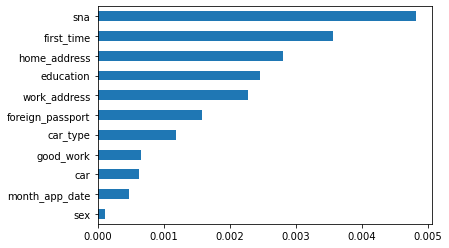

In [56]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'], discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  int64         
 3   sex               110148 non-null  int64         
 4   age               110148 non-null  float64       
 5   car               110148 non-null  int64         
 6   car_type          110148 non-null  int64         
 7   decline_app_cnt   110148 non-null  float64       
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  float64       
 11  region_rating     110148 non-null  float64       
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

Данные для дальнейшей работы имеют формат float и int

## Подготовка данных

Выlелим тестовую часть из data

In [58]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

### Категориальные признаки
Применем OneHotEncoder для кодировки

In [59]:
X_cat_train = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)

In [60]:
X_cat_train.shape

(73799, 24)

In [61]:
X_cat_test.shape

(36349, 24)

Количество строк совпадает с входными данными

### Числовые переменные

Стандартизируем с помощью StandartScale

In [62]:
X_num_train = StandardScaler().fit_transform(train_data[num_cols].values)
X_num_test = StandardScaler().fit_transform(test_data[num_cols].values)

In [63]:
X_num_train.shape

(73799, 6)

In [64]:
X_num_test.shape

(36349, 6)

## Объединяем данные

In [65]:
X = np.hstack([X_num_train, train_data[bin_cols].values, X_cat_train])
X_test = np.hstack([X_num_test, test_data[bin_cols].values, X_cat_test])

In [66]:
X.shape

(73799, 35)

In [67]:
X_test.shape

(36349, 35)

In [68]:
y = train_data['default'].values 

In [69]:
y.shape

(73799,)

Разделим данные для обучения

In [70]:
# разделим данные
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [71]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X_train = np.hstack([np.ones(X_train.shape[0])[:, np.newaxis], X_train])
X_val = np.hstack([np.ones(X_val.shape[0])[:, np.newaxis], X_val])

## Обучаем модель

In [72]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Roc-анализ

In [73]:
probs = model.predict_proba(X_val)
probs = probs[:,1]

In [74]:
fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

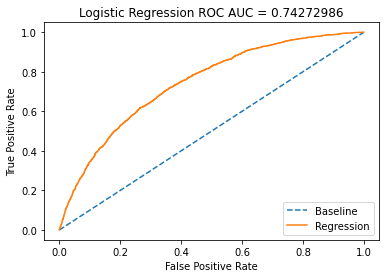

In [75]:
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.8f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Confusion matrix

In [76]:
y_predicted = model.predict(X_val)

In [77]:
confusion_matrix(y_val, y_predicted)

array([[12864,    69],
       [ 1782,    45]])

## Регуляризация

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

In [80]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(-1, 3, 100)

In [81]:
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

In [82]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

In [83]:
reg_model = clf.fit(X_train, y_train)

In [84]:
# View best hyperparameters
print('Лучшее Penalty:', reg_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', reg_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.484968262254465


Roc-анализ

In [85]:
probs_2 = reg_model.predict_proba(X_val)
probs_2 = probs_2[:,1]

In [86]:
fpr, tpr, threshold = roc_curve(y_val, probs_2)
roc_auc_2 = roc_auc_score(y_val, probs_2)

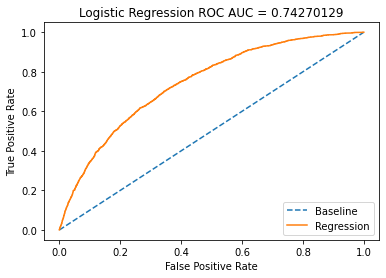

In [87]:
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.8f' % roc_auc_2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [88]:
y_predicted_2 = reg_model.predict(X_val)

In [89]:
confusion_matrix(y_val, y_predicted_2)

array([[12864,    69],
       [ 1782,    45]])

### Submission

#Добавить фиктивный столбец единиц (bias линейной модели)
X_test = np.hstack([np.ones(X_test.shape[0])[:, np.newaxis], X_test])

X_test.shape

sample_submission

predict_submission = model.predict(X_test)

predict_submission

len(predict_submission)

submit = pd.DataFrame(df_test.client_id)
submit['default']=predict_submission
submit.info()

submit.to_csv('submission.csv', index=False)